## Example using IRIS dataset

In [2]:

import pandas as pd

from scivae import VAE, Validate
from sciviso import Scatterplot

# Set the location of the data
config = {'scale': False, # Whether to min max scale your data VAEs work best when data is pre-normalised & outliers removed for trainiing
           'batch_norm': True, 
          'loss': {'loss_type': 'mse', # mean squared error
           'distance_metric': 'mmd', # Maximum mean discrepency (can use kl but it works worse)
            'mmd_weight': 1}, 
          'encoding': {'layers': [{'num_nodes': 1024, 'activation_fn': 'selu'}]}, # First layer of encoding
          'decoding': {'layers': [{'num_nodes': 1024, 'activation_fn': 'selu'}]}, # Second layer of decoding 
 'latent': {'num_nodes': 768}, 'optimiser': {'params': {}, 'name': 'adagrad'}} # Empty params means use default




2024-07-31 14:34:08.795632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 14:34:08.941406: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 14:34:08.946767: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-31 14:34:08.946781: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart d

In [3]:
import pickle

with open('/disk1/ariane/vscode/llms/notebooks/data_processing/protein_embeddings_map.pkl', 'rb') as file:
    protein_df = pickle.load(file)

In [4]:
import numpy as np
df = protein_df[~protein_df['Embedding'].isna()]
protein_data = np.array([np.asarray(x).astype(np.float32) for x in df['Embedding'].values])
protein_data.shape

(100695, 1280)

In [5]:

# Set up what the columns are
vae = VAE(protein_data, protein_data, df.index.values, config, 'vae')
vae.encode('default',  epochs=10, batch_size=100, train_percent=85.0, logging_dir=None, logfile=None,
               early_stop=True)

# Lets have a look at a scatterplot version & apply the class colours to our plot
encoding = vae.get_encoded_data()
decoding = vae.decoder.predict(encoding)

None


2024-07-31 14:34:13.050544: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-31 14:34:13.050621: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-07-31 14:34:13.050666: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-07-31 14:34:13.050707: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-07-31 14:34:13.090678: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

--------------------------------------------------------------------------------
                               Encoder summary:	                                
--------------------------------------------------------------------------------
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 default_input (InputLayer)     [(None, 1280)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 1024)         1311744     ['default_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024)        4096        ['dense[0][0]']                  
 alization)                                    

In [6]:
# Want to save the output of the VAE!
vae.save()

In [9]:
encoding_dict = {}
for i, entry in enumerate(df['Entry'].values):
    encoding_dict[entry] = encoding[i]

In [10]:
with open('encoding_dict.pkl', 'wb') as file:
    pickle.dump(encoding_dict, file)

## Visualise the latent space

Visualise and colour the latent space.


/disk1/ariane/miniconda3/envs/scivae/lib/python3.10/site-packages/sciviso/scatterplot.py:115: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(vis_df[x].values, vis_df[y].values, c=self.colour, alpha=self.opacity,


<AxesSubplot: title={'center': 'Latent space coloured by class'}, xlabel='VAE 0', ylabel='VAE 1'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

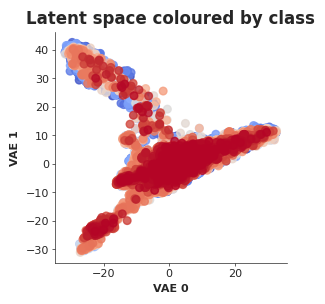

In [11]:
import seaborn as sns
from sklearn.decomposition import PCA 

vis_df = pd.DataFrame()
# Fit and transform the data
pca = PCA(n_components=2)
principal_components = pca.fit_transform(encoding)

# Create a DataFrame with the principal components
vis_df['latent_0'] = principal_components[:, 0]
vis_df['latent_1'] = principal_components[:, 1]
labels = df.index.values
lut = dict(zip(set(labels), sns.color_palette("coolwarm", len(set(labels)))))
row_colors2 = pd.DataFrame(labels)[0].map(lut)
vis_df['label'] = row_colors2
scatter = Scatterplot(vis_df, 'latent_0', 'latent_1', colour=row_colors2, title='Latent space coloured by class',
                      xlabel='VAE 0', ylabel='VAE 1')
scatter.plot()

## Print out the accuracy

Here we just get the accuracy of the encoding space when we use it as features for a classifier.

In [12]:
vd = Validate(encoding, labels)
print(vd.predict('rf', 'accuracy')) # 0.3159318976209268 is not bad for a 8 class problem